$\partial_t \theta = \nabla \omega \times \overrightarrow{\tau}$

In [4]:
from fenics import *
from dolfin import *
#from mshr import *
import matplotlib.pyplot as plt

comm = MPI.comm_world
rank = MPI.rank(comm)

data = HDF5File(comm, f"data_test_count_49_w_0.2236_time_2000.h5", 'r')

In [5]:
mesh = Mesh()
data.read(mesh, "mesh", False)

In [6]:
nx = 60
ny = 60
LX = 128 
LY = 128

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], LY)) or
                        (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY

In [7]:
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim = 2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain = PeriodicBoundary())

VFS = FunctionSpace(mesh, V, constrained_domain = PeriodicBoundary())
FS  = FunctionSpace(mesh, Q, constrained_domain = PeriodicBoundary())

u_new = Function(MFS) 
(rho_new, tau_new) = split(u_new)

w = Function(FS)

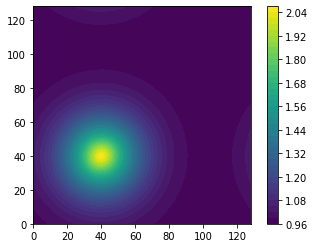

In [8]:
t = 0

data.read(u_new, f"u_new/Vector/vector_{t}")

c = plot(rho_new)
plt.colorbar(c)

0.00018630002687565665
0.00018630002687565665


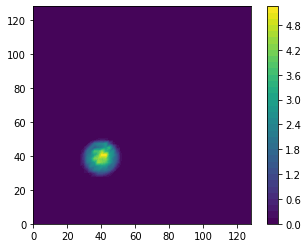

In [9]:
alpha = Function(FS)
data.read(w, f"w/Vector/vector_{t}")
# alpha = project(w*w, FS)
k = w.vector()[:]*w.vector()[:]
alpha.vector().set_local(k)
c = plot(alpha)
plt.colorbar(c)
print(min(w.vector()[:]*w.vector()[:]))
print(min(alpha.vector()[:]))

In [10]:
import numpy as np
x = np.linspace(0, LX, 5*nx)
y = np.linspace(0, LY, 5*ny)
xx, yy = np.meshgrid(x, y, sparse = False, indexing = 'ij')

center of the aster is located at $x_0  = 40$. So we integrate a region of $\Omega$ = $10 \times 128$ in the left and right domain

In [12]:

total_time = 2

right_all = []
left_all = []

for i in range(0, total_time, 2):
    right = []
    left = []
    
    if(i%10 == 0):
        print(i, flush = True)
    
    data.read(w, f"w/Vector/vector_{i}")
    data.read(u_new, f"u_new/Vector/vector_{i}")
    k = w.vector()[:]*w.vector()[:]
    alpha.vector().set_local(k)
    grad_alpha = project(grad(alpha), VFS)
    tau_ = project(tau_new, VFS)
    cross_product = project(tau_.sub(1)*grad_alpha.sub(0) - tau_.sub(0)*grad_alpha.sub(1), FS)
    y = np.linspace(0, LY, 2*ny)
    
    for x0 in range(41, 50):
        
        tau_y = [cross_product(x0, yi) for yi in y]
        right.append(np.sum(tau_y))
        
    right_all.append(np.sum(right))
    
    for x0 in range(30, 40):
        
        tau_y = [cross_product(x0, yi) for yi in y]
        left.append(np.sum(tau_y))
    left_all.append(np.sum(left))

0


<ipython-input-11-fc9c7bf1053d>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x,y,rho.T, cmap = 'seismic')


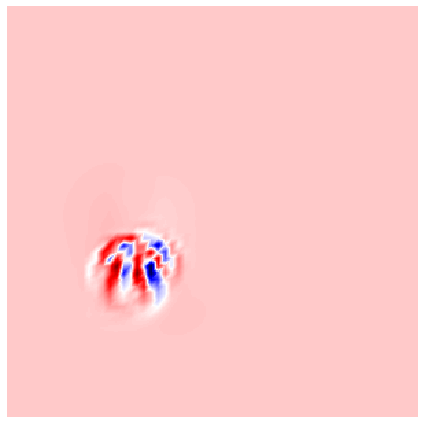

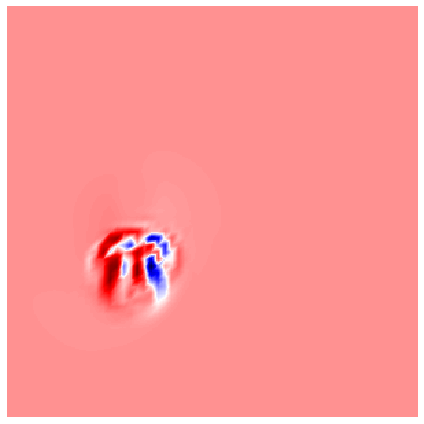

In [11]:
import matplotlib
import os


def plot_torque(cross, i):
    
    if not os.path.exists(f'torque_profiles'):
        os.makedirs(f'torque_profiles')

    rho_ar = np.vectorize(cross)
    rho = rho_ar(xx, yy)
    plt.figure(figsize=(6, 6))
    plt.clf()


    plt.pcolor(x,y,rho.T, cmap = 'seismic')
# #     cbar = plt.colorbar()
# #     tick_font_size = 45
# #     cbar.ax.tick_params(labelsize=tick_font_size)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"torque_profiles/torque_time_{int(0.5*i)}.png", dpi = 300)
    
    

total_time = 8
start = 5

right_all = []
left_all = []

for i in range(start, total_time, 2):
    right = []
    left = []
    
    if(i%10 == 0):
        print(i, flush = True)
    
    data.read(w, f"w/Vector/vector_{i}")
    data.read(u_new, f"u_new/Vector/vector_{i}")
    k = w.vector()[:]*w.vector()[:]
    alpha.vector().set_local(k)
    grad_alpha = project(grad(alpha), VFS)
    tau_ = project(tau_new, VFS)
    cross_product = project(tau_.sub(1)*grad_alpha.sub(0) - tau_.sub(0)*grad_alpha.sub(1), FS)
    plot_torque(cross_product, i)

